# Run py12box model
Run the AGAGE 12-box model

In [1]:
import os
import matplotlib.pyplot as plt
import setup
import core
from ipywidgets import widgets
from IPython.display import display
from pandas import read_csv
from pathlib import Path

In [2]:
input_dir = Path(".") / "inputs"

species_info = read_csv(input_dir / "species_info.csv",
                        index_col = "Species")
#species_list = species_info.index.values
project_paths = [Path('../py12box_projects'), Path(".")]

In [3]:
project_directories_str = "\n".join([str(pth.resolve()) for pth in project_paths])
proj_textarea = widgets.Textarea(value = project_directories_str,
                                description = "Project_directories")
display(proj_textarea)

Textarea(value='/Users/chxmr/Work/Projects/py12box_projects\n/Users/chxmr/Work/Projects/py12box', description=…

In [4]:
class inputs:
    time = None
    ic = None
    emissions = None
    lifetime = None
    mol_mass = None

class inputs_global:
    F = None
    OH = None
    Cl = None
    temperature = None
    

In [17]:
project_directories = []
for proj in project_paths:
    for f in proj.glob("*"):
        if (f.is_dir()) and (str(f.name)[0] != "."):
            project_directories.append(f)

project_dropdown = widgets.Dropdown(options = sorted(project_directories),
                                description = "Select project")

case_dropdown = widgets.Dropdown(options = [None],
                                 description = "Select case")

species_dropdown = widgets.Dropdown(options = [None],
                                    description = "Select species")

def update_case_dropdown(*args):
    project_directory = project_dropdown.value
    cases = sorted([p.name for p in project_directory.glob("*/")])
    case_dropdown.options = cases

project_dropdown.observe(update_case_dropdown, names = "value")
update_case_dropdown()

no_files = False
def update_species_dropdown(*args):
    case = case_dropdown.value
    fnames = [f.name for f in (project_dropdown.value / case).rglob("*.csv")]
    if len(fnames) > 0:
        no_files = False
        species_set = set([f.split("_")[0] for f in fnames])
        species_dropdown.options = species_set
    else:
        no_files = True
        species_dropdown.options = ["ERROR: no files found"]

case_dropdown.observe(update_species_dropdown, names = "value")
update_species_dropdown()

# TODO: make a class to store model inputs.
#FIGURE OUT WHY THIS SEEMS TO BE CALLED BEFORE CASE IS UPDATED
# may be related to this: https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Asynchronous.html

mol_mass = None
species = None
def update_model_inputs(*args):
    if no_files == False:
        print("Updating model inputs")
        project_directory = project_dropdown.value
        case = case_dropdown.value
        species = species_dropdown.value
        inputs.mol_mass = species_info["Molecular mass (g/mol)"][species]
        
        inputs.time, inputs.emissions, inputs.ic, inputs.lifetime = setup.get_species_parameters(project_directory,
                                                                 case,
                                                                 species)

        i_t, i_v1, t, v1, inputs_global.OH, inputs_global.Cl, inputs_global.temperature = setup.get_model_parameters(input_dir,
                                                                       int(len(inputs.time) / 12))
        inputs_global.F = setup.transport_matrix(i_t, i_v1, t, v1)

    else:
        inputs.time = None
        inputs.ic = None
        inputs.emissions = None
        inputs.lifetime = None
        inputs.mol_mass = None

species_dropdown.observe(update_model_inputs, names = "value")
update_model_inputs()

display(project_dropdown)
display(case_dropdown)
display(species_dropdown)


Updating model inputs


Dropdown(description='Select project', options=(PosixPath('../py12box_projects/AGAGE'), PosixPath('../py12box_…

Dropdown(description='Select case', options=('CFC-11',), value='CFC-11')

Dropdown(description='Select species', options=('CFC-11',), value='CFC-11')

Updating model inputs


ToggleButton(value=False, description='Run model', icon='check', tooltip='Description')

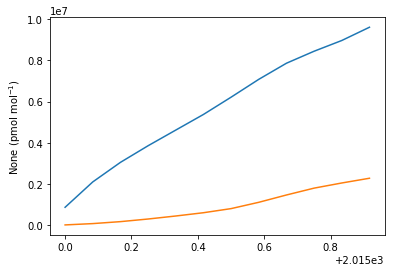

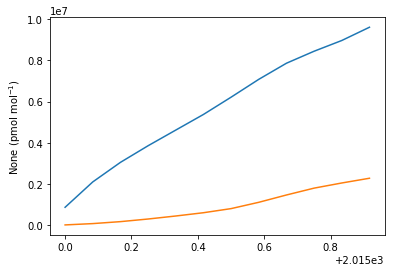

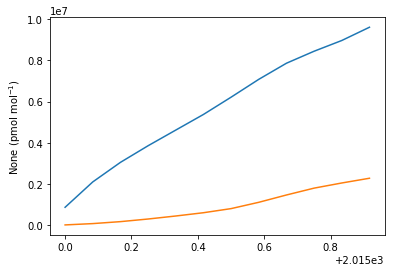

In [23]:
def run_model(*args):
    if len(inputs.emissions) > 0:
    
        c_month, burden, emissions_out, losses, lifetimes = \
            core.model(ic=inputs.ic, q=inputs.emissions,
                       mol_mass=inputs.mol_mass,
                       lifetime=inputs.lifetime,
                       F=inputs_global.F,
                       temp=inputs_global.temperature,
                       Cl=inputs_global.Cl, OH=inputs_global.OH)

        plt.plot(inputs.time, c_month[:, 0])
        plt.plot(inputs.time, c_month[:, 3])
        plt.ylabel("%s (pmol mol$^{-1}$)" % species)
        plt.show()

    else:

        print("No inputs")
    
run_botton = widgets.ToggleButton(
                                value=False,
                                description='Run model',
                                disabled=False,
                                button_style='', # 'success', 'info', 'warning', 'danger' or ''
                                tooltip='Description',
                                icon='check'
                                )

display(run_botton)
run_botton.observe(run_model, names = "value")
